In [1]:
!pip install ultralytics==8.0.196

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 4.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
from ultralytics.utils.metrics import ConfusionMatrix
from sklearn.metrics import classification_report
from ultralytics import YOLO
import numpy as np
import pandas as pd


In [3]:
import os
os.environ["WANDB_API_KEY"] = "aca9cf829fa45dbb446b7c861f28378794d2fee7"


In [4]:
# Load a model

use_gpu = True  # Set to True if you want to use GPU
device = 'cuda' 

from torch.optim import Adam

# Load a model with GPU if available
model = YOLO('yolov8n-cls.pt')


# Instantiate the Adam optimizer with the desired learning rate
#dropout = 0.2  # Dropout rate

# Train the model with optimizer, learning rate, and dropout
results = model.train(data='/kaggle/input/d/insafben/mri-dataset/cleaned', epochs=20, device=device,batch=2, imgsz=256, verbose=False)


100%|██████████| 5.28M/5.28M [00:00<00:00, 58.2MB/s]
New https://pypi.org/project/ultralytics/8.2.12 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/kaggle/input/d/insafben/mri-dataset/cleaned, epochs=20, patience=50, batch=2, imgsz=256, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, st

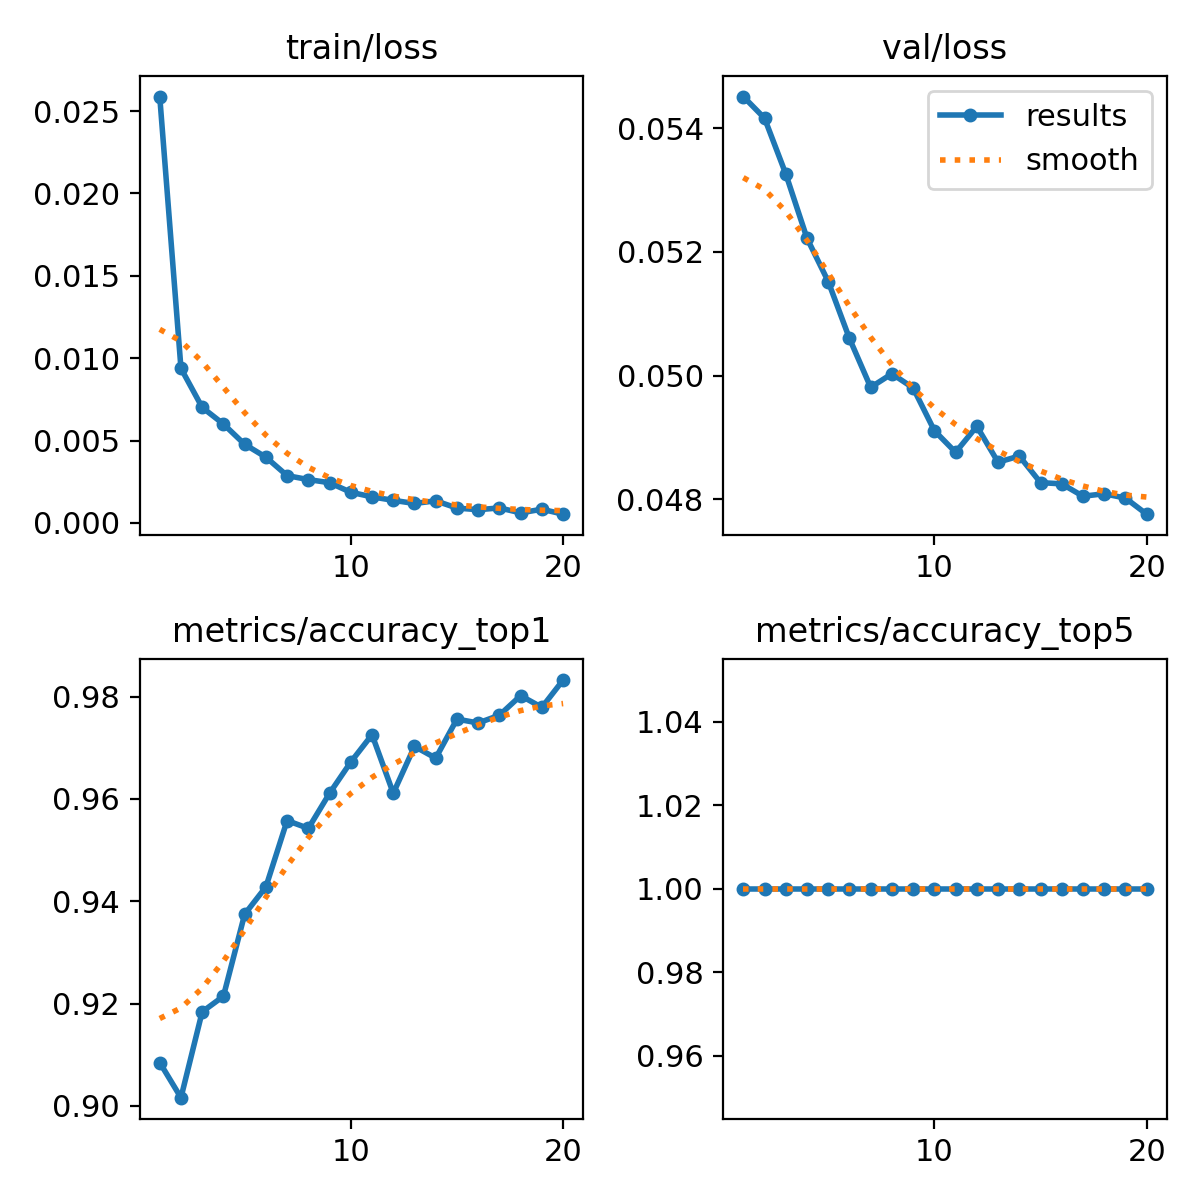

In [5]:
from PIL import Image
Image.open('/kaggle/working/runs/classify/train/results.png')

In [6]:
# Evaluate the model on the validation set
metrics = model.val(data='/kaggle/input/d/insafben/mri-dataset/cleaned',device=device, verbose=False,imgsz=256)
metrics

Ultralytics YOLOv8.0.196 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n-cls summary (fused): 73 layers, 1440004 parameters, 0 gradients, 3.3 GFLOPs
train: /kaggle/input/d/insafben/mri-dataset/cleaned/train... found 5712 images in 4 classes ✅ 
val: /kaggle/input/d/insafben/mri-dataset/cleaned/val... found 1311 images in 4 classes ✅ 
test: None...
val: Scanning /kaggle/input/d/insafben/mri-dataset/cleaned/val... 1311 images, 0 corrupt: 100%|██████████| 1311/1311 [00:00<00:00, 1925.63it/s]
val: WARNING ⚠️ Cache directory /kaggle/input/d/insafben/mri-dataset/cleaned is not writeable, cache not saved.
               classes   top1_acc   top5_acc: 100%|██████████| 656/656 [00:04<00:00, 160.32it/s]
                   all      0.983          1
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d234ac16740>
fitness: 0.9916094839572906
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9832189679145813, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9916094839572906}
save_dir: PosixPath('runs/classify/val')
speed: {'preprocess': 0.16325853145549898, 'inference': 2.5406574857407724, 'loss': 0.009066452969129899, 'postprocess': 0.008899687265822399}
top1: 0.9832189679145813
top5: 1.0

In [7]:
metrics.confusion_matrix.matrix

array([[        287,           0,           0,           0],
       [         10,         304,           2,           5],
       [          2,           2,         403,           0],
       [          1,           0,           0,         295]])

In [8]:
import os
import pandas as pd
import multiprocessing
import cv2
import numpy as np
from sklearn.metrics import accuracy_score

# Val Dataset path
path = "/kaggle/input/d/insafben/mri-dataset/cleaned/val"

key_value= dict()
for i in os.listdir(path):
    key_value[i] = os.listdir(path+'/'+i)
dft = []

for key in key_value.keys():
    for j in key_value[key]:
        dft.append([key,path+'/'+key+'/'+j])
dft = pd.DataFrame(dft,columns=('label','path'))

    

# Convert labels to numerical values
test_labels = dft['label'].replace({'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}).values

# Initialize predictions array
predictions = []

# Iterate through each image
for image in dft['path']:
    # Make prediction on the image
    results = model.predict(image, verbose=False,imgsz=256)
    prediction = results[0].probs.top1 # Extract predicted class index
    predictions.append(prediction)

# Convert predictions to numpy array
predictions = np.array(predictions)




/tmp/ipykernel_25/1271683148.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_labels = dft['label'].replace({'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}).values


In [9]:
target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

report=classification_report(test_labels, predictions,target_names=target_names, output_dict=True)
print(report)

{'glioma': {'precision': 1.0, 'recall': 0.9566666666666667, 'f1-score': 0.9778534923339013, 'support': 300}, 'meningioma': {'precision': 0.9470404984423676, 'recall': 0.9934640522875817, 'f1-score': 0.9696969696969696, 'support': 306}, 'notumor': {'precision': 0.9901719901719902, 'recall': 0.9950617283950617, 'f1-score': 0.9926108374384236, 'support': 405}, 'pituitary': {'precision': 0.9966216216216216, 'recall': 0.9833333333333333, 'f1-score': 0.9899328859060402, 'support': 300}, 'accuracy': 0.9832189168573608, 'macro avg': {'precision': 0.9834585275589949, 'recall': 0.9821314451706609, 'f1-score': 0.9825235463438337, 'support': 1311}, 'weighted avg': {'precision': 0.9838295461704859, 'recall': 0.9832189168573608, 'f1-score': 0.9832727500852911, 'support': 1311}}


In [10]:
from sklearn.metrics import accuracy_score



# Compute the accuracy score
accuracy = accuracy_score(test_labels, predictions)

print('Accuracy:', accuracy)

Accuracy: 0.9832189168573608


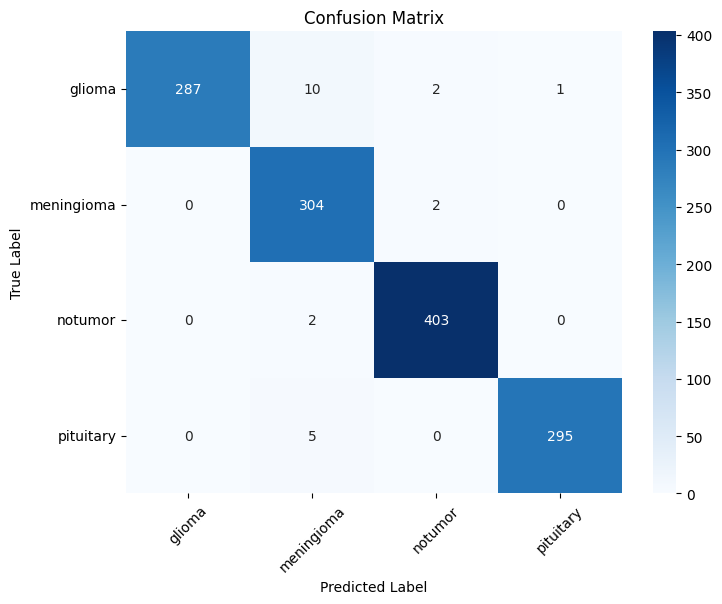

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


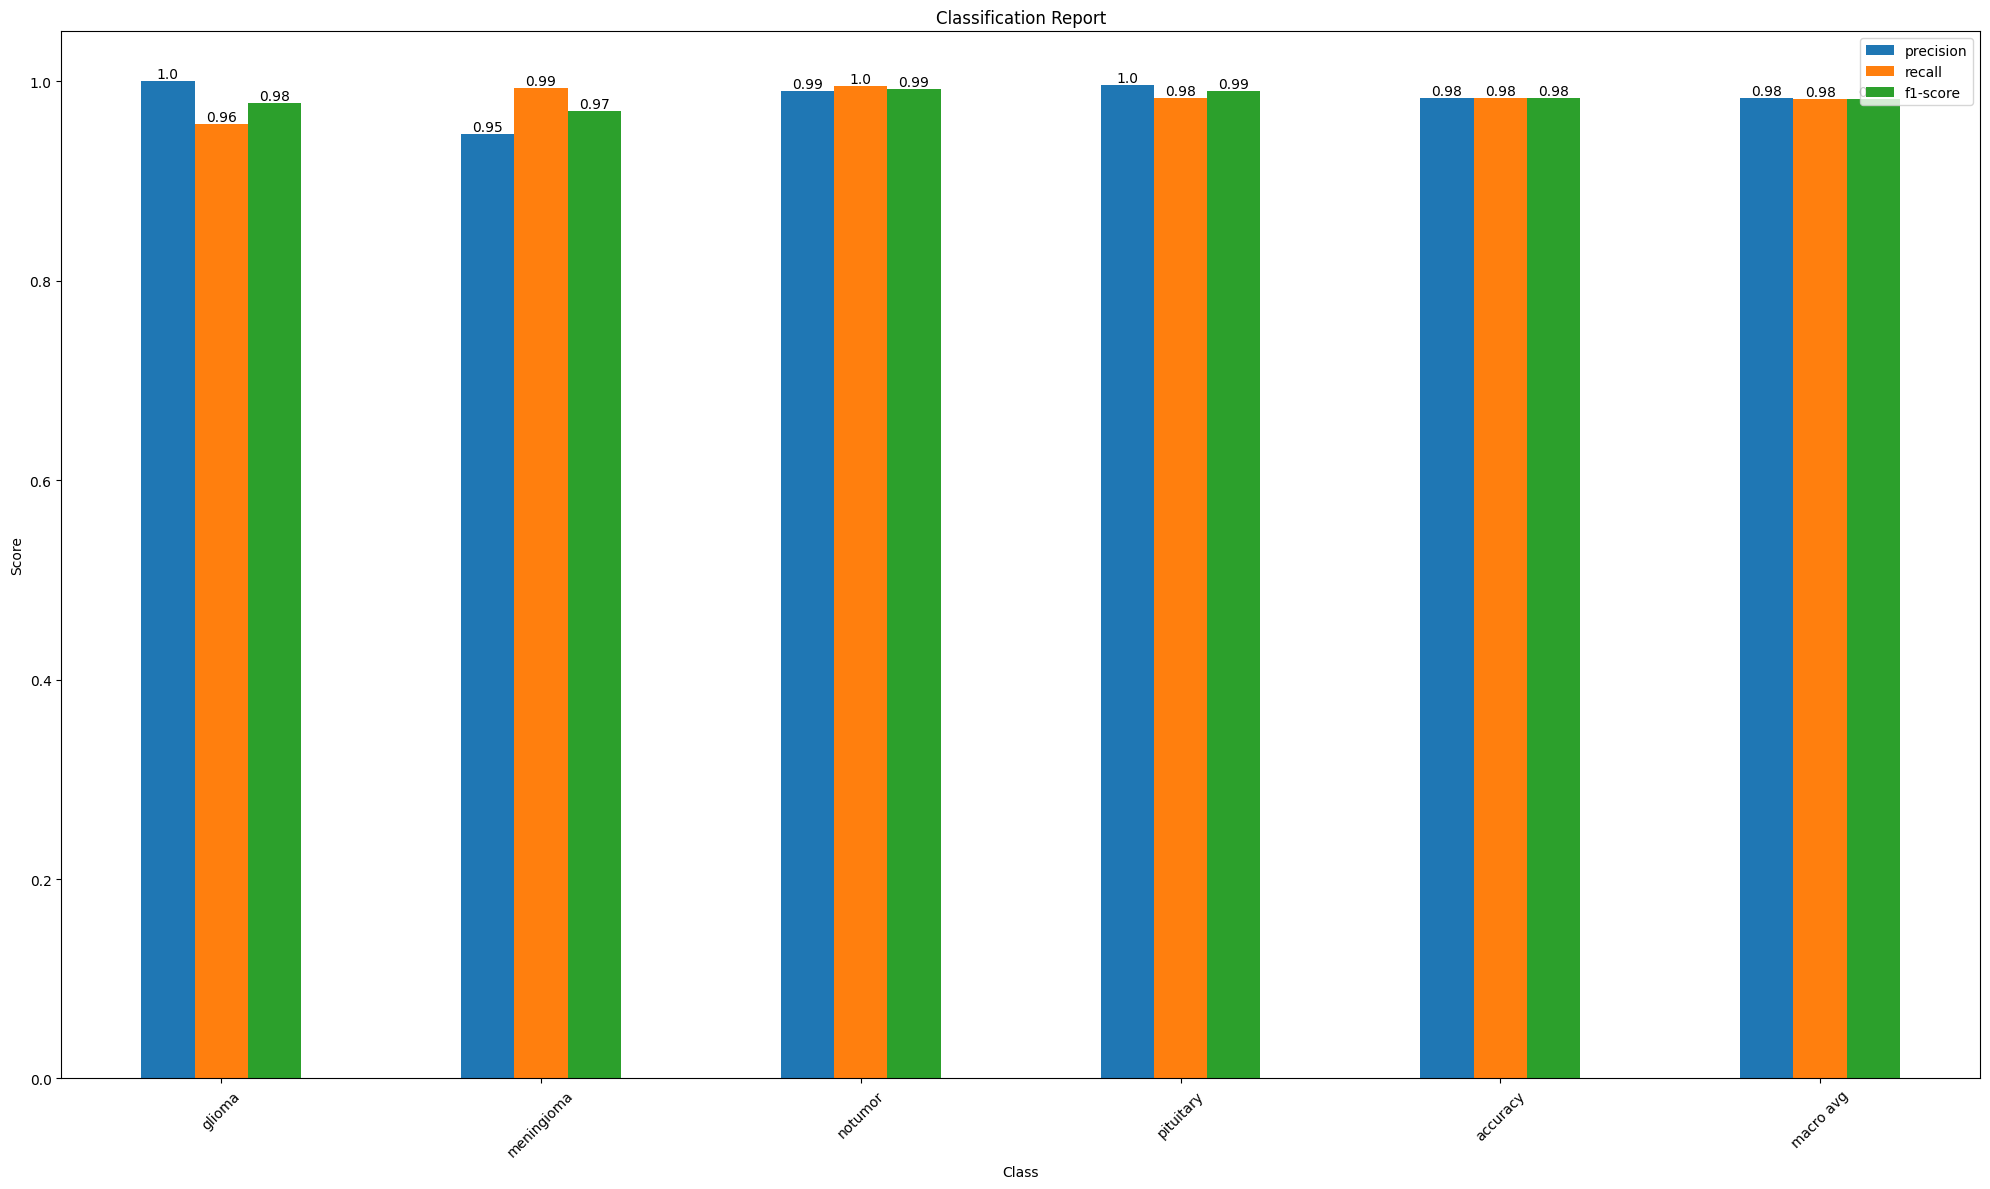

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Assuming you have defined target_names as a list of class names
target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']


# Convert report dictionary to DataFrame for easy plotting
df_report = pd.DataFrame(report).transpose()

# Plot precision, recall, and F1-score for each class
df_plot = df_report[['precision', 'recall', 'f1-score']].iloc[:-1]
ax = df_plot.plot(kind='bar', figsize=(20, 12))
plt.title('Classification Report')
plt.xlabel('Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper right')

# Annotate each bar with its respective score
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)),
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [13]:
import time
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications.resnet50 import preprocess_input


# Initialize variables to store processing times
processing_times = []

# Iterate through each test image
for image in dft['path']:
    # Measure start time
    start_time = time.time()
    
    # Make prediction on the preprocessed test image
    prediction = model.predict(image,verbose=False)  # Expand dimensions to match batch shape
    
    # Measure end time
    end_time = time.time()
    
    # Calculate processing time
    processing_time = end_time - start_time
    
    # Store processing time
    processing_times.append(processing_time)

# Compute average processing time
average_processing_time = sum(processing_times) / len(processing_times)

# Print the average processing time
print("Average Processing Time:", average_processing_time)


Average Processing Time: 0.006770100873631435


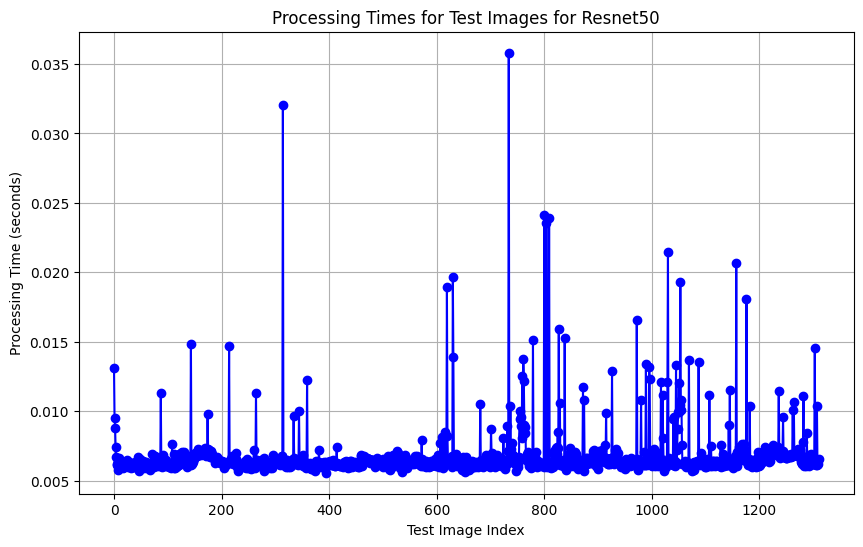

Average Processing Time: 0.006770100873631435


In [14]:
# Plot processing times
plt.figure(figsize=(10, 6))
plt.plot(processing_times, color='blue', marker='o', linestyle='-')
plt.title('Processing Times for Test Images for Resnet50')
plt.xlabel('Test Image Index')
plt.ylabel('Processing Time (seconds)')
plt.grid(True)
plt.show()

# Print the average processing time
print("Average Processing Time:", average_processing_time)

In [15]:
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [16]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    metrics = []

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        fn = sum(confusion_matrix[i, j] for j in range(num_classes) if j != i)
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i) - fn
        
        metrics.append((tp, fp, fn, tn))

    return metrics

# Calculate metrics for each class
class_metrics = calculate_metrics(conf_matrix)

# Print results for each class
for i, (tp, fp, fn, tn) in enumerate(class_metrics):
    print(f"{classes[i]}:")
    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("False Negatives (FN):", fn)
    print("True Negatives (TN):", tn)
    print()


glioma:
True Positives (TP): 287
False Positives (FP): 0
False Negatives (FN): 13
True Negatives (TN): 989

meningioma:
True Positives (TP): 304
False Positives (FP): 17
False Negatives (FN): 2
True Negatives (TN): 983

notumor:
True Positives (TP): 403
False Positives (FP): 4
False Negatives (FN): 2
True Negatives (TN): 884

pituitary:
True Positives (TP): 295
False Positives (FP): 1
False Negatives (FN): 5
True Negatives (TN): 989



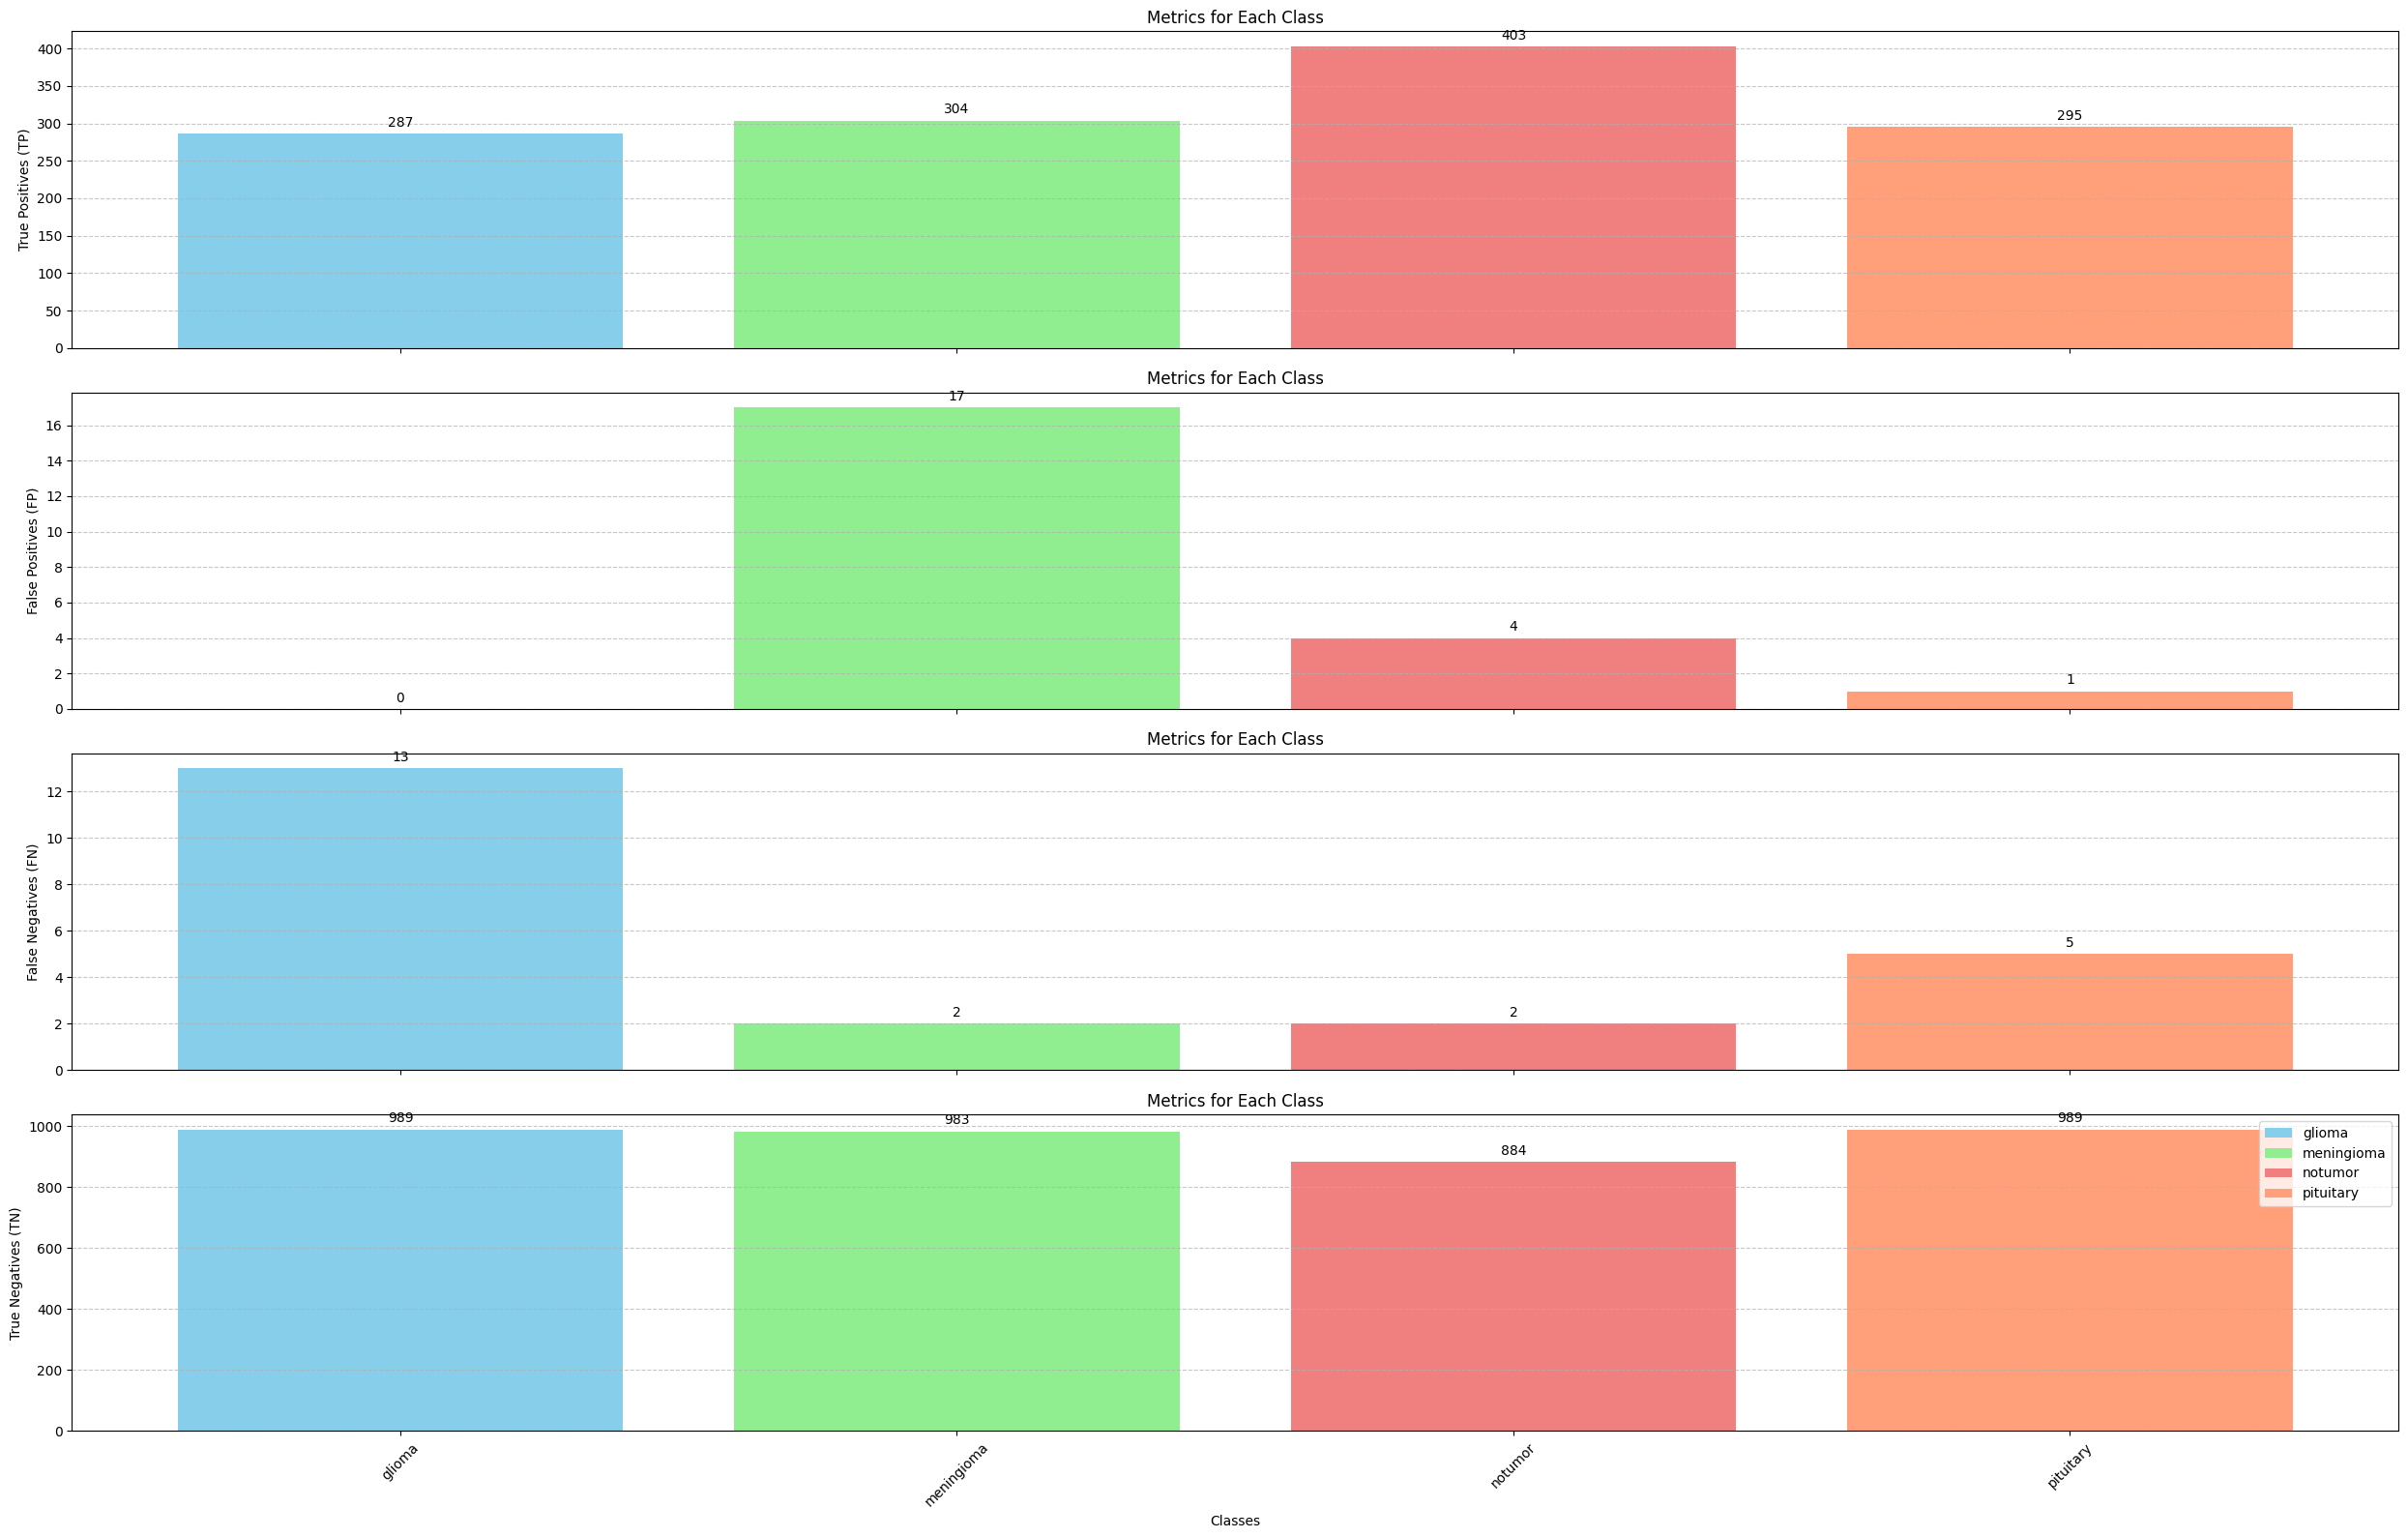

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Define function to plot metrics
def plot_metrics(class_metrics, classes):
    # Convert metrics to numpy array for easier indexing
    metrics_array = np.array(class_metrics)
    num_metrics = metrics_array.shape[1]  # Number of metrics (TP, FP, FN, TN)

    # Define colors for each metric
    colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightsalmon']
    metrics_labels = ['True Positives (TP)', 'False Positives (FP)', 'False Negatives (FN)', 'True Negatives (TN)']

    # Create subplots for each metric
    fig, axes = plt.subplots(nrows=num_metrics, ncols=1, figsize=(25, 16), sharex=True)

    # Plot each metric with different color for each class
    for i in range(num_metrics):
        ax = axes[i]
        for j in range(len(classes)):
            bar = ax.bar(classes[j], metrics_array[j, i], color=colors[j], label=classes[j])
            # Annotate each bar with its respective score
            for rect in bar:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')
        ax.set_ylabel(metrics_labels[i])
        ax.set_title(f'Metrics for Each Class')
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Classes')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend(loc='upper right')  # Show legend for class colors
    plt.tight_layout()
    plt.show()

# Plot metrics for each class
plot_metrics(class_metrics, classes)


In [18]:
def calculate_accuracy(tp, fp, fn, tn):
    if tp + fp + fn + tn == 0:
        return 0  # Handling division by zero
    return (tp + tn) / (tp + fp + fn + tn)

def calculate_acc_each_class(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    metrics = []

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        fn = sum(confusion_matrix[i, j] for j in range(num_classes) if j != i)
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i) - fn

        accuracy = calculate_accuracy(tp, fp, fn, tn)
        metrics.append(accuracy)

    return metrics

# Calculate metrics for each class
class_metrics = calculate_acc_each_class(conf_matrix)

# Print results for each class
for i, accuracy in enumerate(class_metrics):
    print(f"{classes[i]}: Accuracy {accuracy:.2f}")



glioma: Accuracy 0.99
meningioma: Accuracy 0.99
notumor: Accuracy 1.00
pituitary: Accuracy 1.00


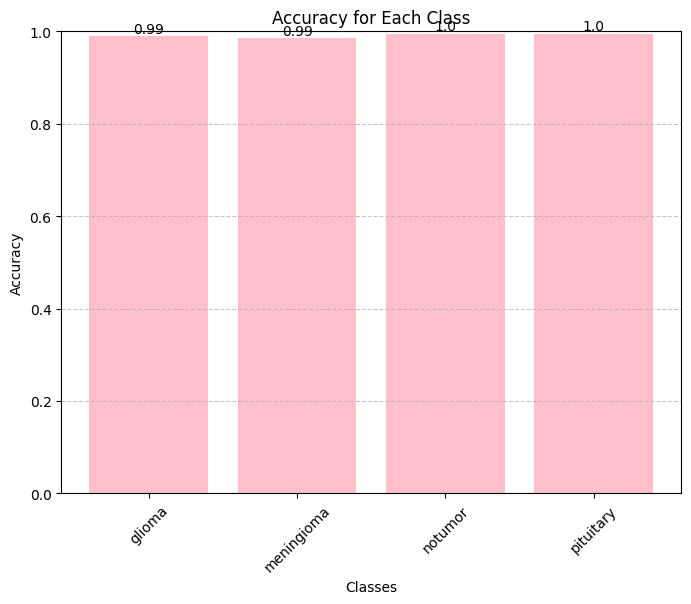

In [19]:
# Plot results for each class
plt.figure(figsize=(8, 6))
bars = plt.bar(classes, class_metrics, color='pink')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Class')
plt.ylim(0, 1)  # Set y-axis limits to ensure consistency
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its respective score
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)),
             ha='center', va='bottom')

plt.show()


In [20]:
def calculate_specificity(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    specificity = [0] * num_classes
    for i in range(num_classes):
        tn = sum(confusion_matrix[j, j] for j in range(num_classes) if j != i)
        fp = sum(confusion_matrix[j, i] for j in range(num_classes) if j != i)
        if tn + fp != 0:
            specificity[i] = tn / (tn + fp)
    return specificity


# Calculate specificity for each class
specificity = calculate_specificity(conf_matrix)

# Print the specificity for each class
for i, spec in enumerate(specificity):
    print(f"{classes[i]}: Specificity {spec:.2f}")


glioma: Specificity 1.00
meningioma: Specificity 0.98
notumor: Specificity 1.00
pituitary: Specificity 1.00


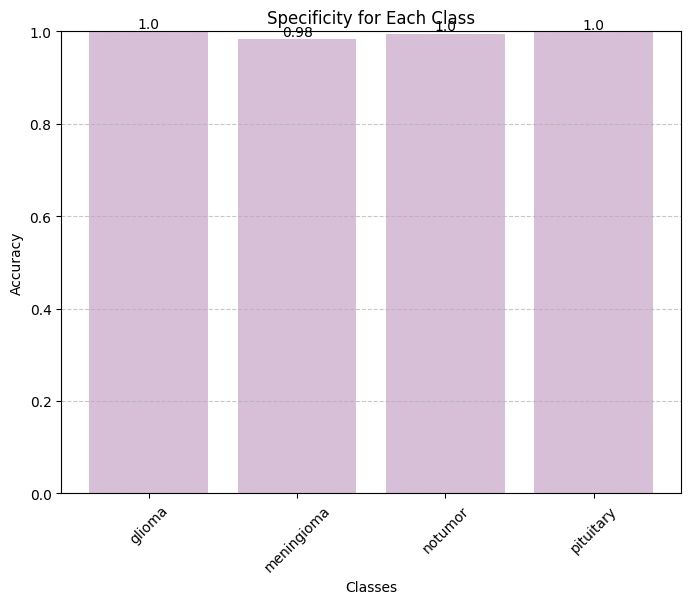

In [21]:
# Plot results for each class
plt.figure(figsize=(8, 6))
bars = plt.bar(classes, specificity, color='thistle')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Specificity for Each Class')
plt.ylim(0, 1)  # Set y-axis limits to ensure consistency
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate each bar with its respective score
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(round(height, 2)),
             ha='center', va='bottom')

plt.show()


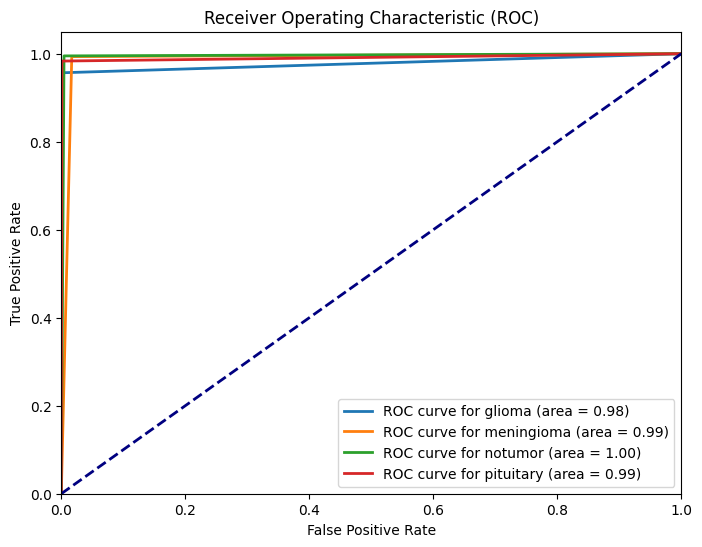

In [22]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(target_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels == i, predictions == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(target_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve for {0} (area = {1:0.2f})'.format(target_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


<Figure size 2400x1200 with 0 Axes>

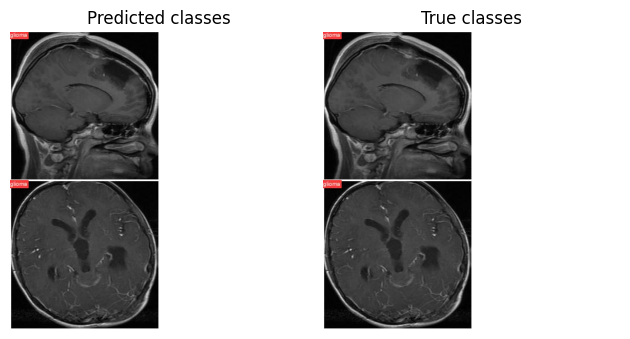

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

predicted = Image.open('/kaggle/working/runs/classify/val/val_batch2_pred.jpg')
labels = Image.open('/kaggle/working/runs/classify/val/val_batch2_labels.jpg')

# Increase the size of the figure
plt.figure(figsize=(24, 12))

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2)
# Display first image
axes[0].imshow(predicted)
axes[0].axis('off')  # Hide axis
axes[0].set_title('Predicted classes')

# Display second image
axes[1].imshow(labels)
axes[1].axis('off')  # Hide axis
axes[1].set_title('True classes')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
